Copyright 2019 Willian Fuks

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Going To Production

So far we've learned about the inner workings of the neighborhood algorithm, one of the main approaches as documented in the field of Collaborative Filtering.

We already know how to read the data, prepare it for building the customers interactions matrix and finally how to use this information to build the famous "similarity matrix".

After that, we learned that a simple `dot` matrix operation between customers interactions and the similarity matrix would result in our desired recommendations.

Still, there's one problem. The system we built **simply can't perform in production environment**.

Developing models for small tests and prototyping is quite easy. But when we need to put those models into stress by facing thousands and thousands of requests, that's when the game really begins.

In order to prepare our model to face production reality, we'll no longer use what we've developed so far.

And for starters, we'll change numpy/scipy with Tensorflow. Not that numpy is not ready for production environments, reality is quite the opposite. It's just that Tensorflow will offer us a complete enviornment that is scalable and robust enough to handle real requests.

With no further ado, let's dig in into Tensorflow framework.

# 1. Tensorflow

In [1]:
import tensorflow as tf

Tensorflow (TF for short) is basically just like numpy. The main difference though is that all operations are lazy (not true if running in `eager mode`; more on that later).

The big insight TF team had when developing the tool was to make it a framework for computing linear algebra operations by the flow of operations in a graph.

Let's see with examples what that means. Let's implement some simple code in number and then in tensorflow to see the differences:

In [2]:
import numpy as np

In [4]:
a = np.array([1, 2, 3])
b = np.array([2, 3, 4]).T

c = a.dot(b)
print(c)

20


In [20]:
tf.reset_default_graph()
a = tf.constant([1, 2, 3], name='input_a')
b = tf.constant([2, 3, 4], name='input_b')

c = tf.tensordot(a, b, 1, name='result_c')
print(c)

Tensor("result_c:0", shape=(), dtype=int32)


Tensorflow does not run code immedietaly: first it builds a graph. In order to run the code, we need to create the `Session` object and directly ask it to run the graph, as shown below:

In [21]:
with tf.Session() as sess:
    writer = tf.summary.FileWriter('/tmp/papis/logs', sess.graph)
    c_ = sess.run(c)
    print(c_)
    writer.close()

20


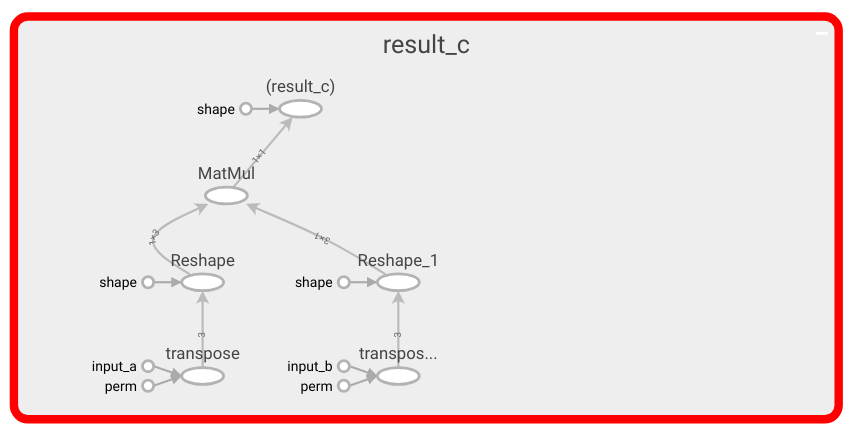

The graph above was built using [Tensorboard](https://www.tensorflow.org/guide/summaries_and_tensorboard). We won't be using much this tool here but keep in mind that in your day to day development this tool is sometimes mandatory for grah debugging issues. 

Everything else will be pretty close to the Numpy code we have seen so far: there are matrices, linear algebra operations, sum of numbers, division, multiplication and so on.

The main difference will be the "lazyness" of the operators as they first build a graph and then finally execute it when a session is created for doing so.

In [29]:
a = tf.constant([[1, 2, 3],
                [4, 5, 6],
                [7, 8, 9]], dtype=tf.float32)

b = tf.eye(3, 3)

c = tf.tensordot(a, b, 1)

with tf.Session() as sess:
    print(sess.run(c))

[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]


In [36]:
a = tf.constant([[1, 2, 3],
                [4, 5, 6],
                [7, 8, 9]], dtype=tf.float32)

b = tf.constant([1, 0, 1], dtype=tf.float32)

c = tf.tensordot(a, b, 1)

with tf.Session() as sess:
    print(sess.run(c))

[ 4. 10. 16.]


In [37]:
a = tf.constant([1, 2, 3])
b = a + 1

with tf.Session() as sess:
    print(sess.run(b))

[2 3 4]


All previous operations on our recommender system that we built by using Numpy now will have to be updated to Tensorflow so that we can work with the graph representation.

By doing so, we start using [dataflow](https://en.wikipedia.org/wiki/Dataflow_programming) programming architecture for our model which is ready to scale up for highly demanding scenarios whilst being light, fast and robuts.

Keep in mind though: **Tensorflow is huge**. It's not just a graph builder but rather a holistic approach for tackling down machine learning problems from the most simple to the most demanding and complex ones.

If you know how to properly use TF then you can deal with any machine learning challenging that might arise in your way.

We won't see much deeper tools from TF as this is not quite the purpose of this workshop; we want to focus on building a reliable recommender system that, despite being simple in terms of algorithm complexity, can be deployed safely into production.

This won't require a deep knowledge of TF but still, we'll face some tough challenges soon with this tool.

Talking about challenges, let us get our hands dirty with TF coding ;)!

In [56]:
def get_tf_recommendations(sim_matrix, user_vector):
    """
    This exercise is similar to the numpy version we've seen so far but this time,
    input will be tensors as defined in TensorFlow. the challenge here is to use
    the tensor similarity matrix and the user input to find the recommendations
    vector. Remember to sort the vector from best suggestion first to worst last.
    
    Also, in order to run the code in TF, it's required to first instantiate a
    `tf.Session` object and use it to run the desired code.
    
    Args
    ----
      sim_matrix: tf.Tensor(dtype=int32)
          Similarity squared and symmetric matrix between skus.
      user_vector: tf.Tensor(dtype=float32)
          Just like in the numpy version, it's a vector representing what skus
          the given customer has interacted with (the r_ui values)
          
    Returns
    -------
      recos: tf.Tensor
          Vector containing the indices for which skus should be recommended from
          best to worst.
    """
    # Here we'll need to use only tensorflow operations. Remember, first we need a dot product
    # between customer vector and sim matrix, this can be obtained with `tf.tensordot`.
    
    # Then we need to retrieve top k values which can be accomplished with `tf.nn.top_k`
    recos = # ... your code here ...
    
    with tf.Session() as sess:
        recos_ = sess.run(recos)

    return recos_.indices

sim_matrix = tf.constant([[1, 2, 3],
                          [4, 5, 6],
                          [7, 8, 9]])
user_vector = tf.constant([1, 0 , 3], dtype=tf.float32)

expected = np.array([2, 1, 0])

result = get_tf_recommendations(sim_matrix, user_vector)
np.testing.assert_array_equal(result, expected)

You may have noticed in this exercise that it's not that fun to develop and test with TF code as everything we have to do in the framework has its processing delayed until we confirm its execution in the session context.

With this in mind, TF team came up with a neat solution: eager mode.

In eager mode, the lazyness for operations is removed and tensors are executed as soon as they are created.

This is quite handy when we are playing around and testing models on the fly. Let's see what changes in eager mode.

First, we'll need to reset the Kernel as otherwise TF will block eager execution.

In [2]:
import tensorflow as tf


tf.enable_eager_execution()

In [4]:
a = tf.constant([[1, 2, 3],
                [4, 5, 6],
                [7, 8, 9]], dtype=tf.float32)

print(a)

tf.Tensor(
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]], shape=(3, 3), dtype=float32)


In [9]:
a = tf.constant([[1, 2, 3],
                [4, 5, 6],
                [7, 8, 9]], dtype=tf.float32)

b = tf.constant([1, 0, 1], dtype=tf.float32)

c = tf.tensordot(a, b, 1)
print(c)

tf.Tensor([ 4. 10. 16.], shape=(3,), dtype=float32)


With eager enabled, let's build again our recommender function.

In [13]:
assert tf.executing_eagerly()
import numpy as np


def get_tf_recommendations(sim_matrix, user_vector):
    """
    This exercise is similar to the numpy version we've seen so far but this time,
    input will be tensors as defined in TensorFlow. the challenge here is to use
    the tensor similarity matrix and the user input to find the recommendations
    vector. Remember to sort the vector from best suggestion first to worst last.
    
    Also, in order to run the code in TF, it's required to first instantiate a
    `tf.Session` object and use it to run the desired code.
    
    Args
    ----
      sim_matrix: tf.Tensor(dtype=int32)
          Similarity squared and symmetric matrix between skus.
      user_vector: tf.Tensor(dtype=float32)
          Just like in the numpy version, it's a vector representing what skus
          the given customer has interacted with (the r_ui values)
          
    Returns
    -------
      recos: tf.Tensor
          Vector containing the indices for which skus should be recommended from
          best to worst.
    """
    # Copy and paste your code from previous exercise. Notice here we don't need the session ;)
    recos = # ... code from previous exercise ...
    return recos.indices

sim_matrix = tf.constant([[1, 2, 3],
                          [4, 5, 6],
                          [7, 8, 9]])
user_vector = tf.constant([1, 0 , 3], dtype=tf.float32)

expected = np.array([2, 1, 0])

result = get_tf_recommendations(sim_matrix, user_vector)
np.testing.assert_array_equal(result, expected)

As you can see, much easier ;)!

# 2. Transform

When we work to implement machine learning models into production, they more or less follow this flow:

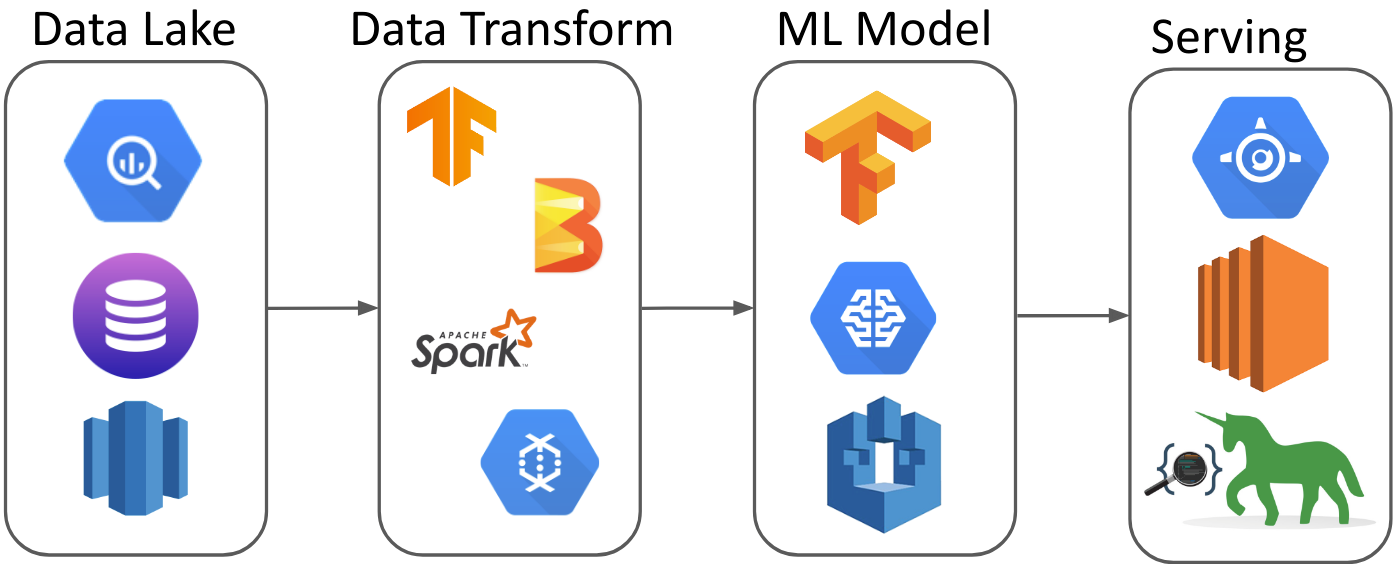

First, we have our **Data Lake**.

This is where data lies. For this workshop, we have selected real data from Dafiti and saved it in a public dataset in BigQuery.

Other possibilites are Amazon Redshift, s3, GCS, PostgreSQL, Hive and so on.

We then proceed to retrieve this data and **Transform** it (like an ETL process) and save the results in some storage system where our ML Models can easily retrieve the data and build itself.

In our case, the transform phase is where we, for instance, enumerate customers and skus to an integer based mapping (remember we did so in our previous notebook in the `build_mapping` task), filter out customers that may not be appropriate for us (such as customers that had zero or just one interaction) and so on.

It may sound simple but here lies one very big challenge: our input data can have hundreds up to thousands of gigabytes.

If this is the case, we need a distributed system to process this massive dataset.

So, with no futher ado, let us learn about **Tensorflow Transform + Apache Beam**.

## 2.1 Apache Beam

[Beam](https://beam.apache.org/) is, in a nutshell, a freaking awesome tool.

Learning Beam programming will give you an immense advantage at being able to process data and manipulate them at will.

Basically Apache Beam works in a similar manner as Tensorflow: it first builds a graph with the desired operations and then executes this graph on a set of distributed machines.

It works by first defining an input Pipeline and then applying whatever transformations might suit one needs to achieve desired results.

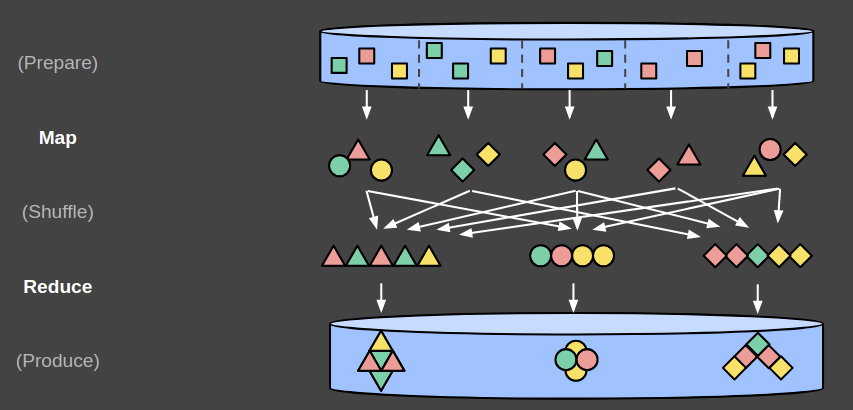

The neat trick is that we can scale up the processing steps for as many machines as we see fit (or our budget sees fit*).

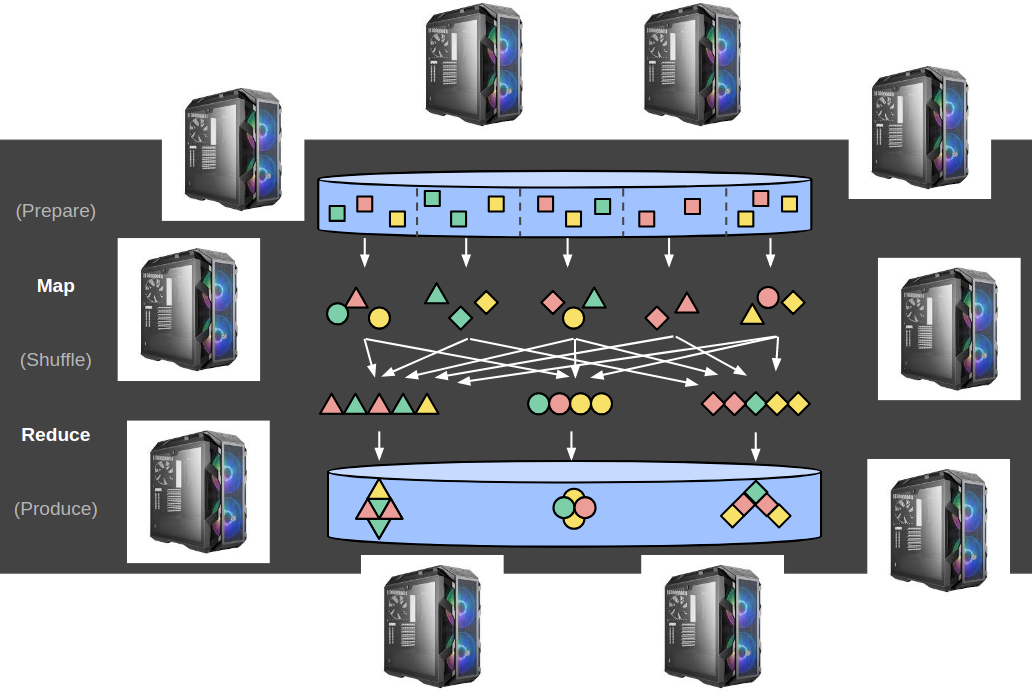

Beam is considered a unified model for processing datasets. As such, we can choose what engine the graphs will execute on. In this workshop, we'll be using two types of runners (engines): `DirectRunner` which uses local CPUs and `Dataflow` which is a parallel distributed architecture for data processing available in GCP (think of it similar to Spark).

If one wants to use another Cloud provider for instance, it's possible to select as engine the Apache Spark software as well.

Enough with the talking, let's get our hands dirty to see how we should operate with Apache Beam. To begin with, we'll need Python2 (support for Python 3 is on the way but not complete yet).

We'll be using the file `../tests/fixtures/transform/input_data_mock.json` here, which simulates data we'd retrieve from our BigQuery database:

In [1]:
train_file_mock = '../tests/fixtures/transform/input_train_data_mock.json'

In [2]:
open(train_file_mock).readlines()

['{"date": "2017-01-01", "hits": [{"action": None, "hitNumber": 1, "productSku": "sku0", "sourcePropertyDisplayName": "XYRbAGwLMn2krcuXpu7J4GL5R1OkUtnsn3kRrYvVNe8="}, {"action": None, "hitNumber": 1, "productSku": "sku1", "sourcePropertyDisplayName": "6+yS0Eo3J1v53F8z40WSn/zk4c/eUKTC/RyaD0Cua9M="}, {"action": "Browsed", "hitNumber": 2, "productSku": "sku1", "sourcePropertyDisplayName": "6+yS0Eo3J1v53F8z40WSn/zk4c/eUKTC/RyaD0Cua9M="}], "customer_id": "customer0"}\n',
 '{"date": "2017-01-01", "hits": [], "customer_id": "customer1"}\n',
 '{"date": "2017-01-02", "hits": [{"action": "Browsed", "hitNumber": 1, "productSku": "sku0", "sourcePropertyDisplayName": "XYRbAGwLMn2krcuXpu7J4GL5R1OkUtnsn3kRrYvVNe8="}, {"action": "AddedToBasket", "hitNumber": 2, "productSku": "sku0", "sourcePropertyDisplayName": "6+yS0Eo3J1v53F8z40WSn/zk4c/eUKTC/RyaD0Cua9M="}], "customer_id": "customer2"}\n',
 '{"date": "2017-01-03", "hits": [{"action": "Browsed", "hitNumber": 1, "productSku": "sku1", "sourcePropertyDi

In [6]:
import ast
import six
import apache_beam as beam
# Beam Pipelines must receive a set of config options to set how it should run.
from apache_beam.options.pipeline_options import PipelineOptions


assert six.PY2

options = {
    'runner': 'DirectRunner'
}

pipeline_options = PipelineOptions(**options)

# we start by instantiating a context with a pipeline object.
# notice it's similar to tensorflow's Session instantiation.
with beam.Pipeline(options=pipeline_options) as pipeline:
    result = (
        pipeline
        # we "pipe" the pipeline into transformations which result in 
        # what is called "PCollection".
        | 'read' >> beam.io.ReadFromText(train_file_mock)
        | 'to json' >> beam.Map(lambda x: ast.literal_eval(x))
        | 'get customer' >> beam.Map(lambda x: x['customer_id'])
        | 'write' >> beam.io.WriteToText('/tmp/papis/t1')
    )
    r = pipeline.run()
    r.wait_until_finish()

result = open('/tmp/papis/t1-00000-of-00001').read().strip().split('\n')
assert result == ['customer0', 'customer1', 'customer2', 'customer0', 'customer0', 'customer2', 'customer4']

We can do lots of operations in Beam such as filtering (for instance, `beam.Filter(condition)`), counting, grouping by key, combining by key and so on.

The official docs are a good place to see what's possible as well as playing around in this notebook will already give some insights about the tool inner workings.

As an example, let's now filter out customers who had no interaction in our database:

In [9]:
assert six.PY2

options = {
    'runner': 'DirectRunner'
}

pipeline_options = PipelineOptions(**options)

with beam.Pipeline(options=pipeline_options) as pipeline:
    result = (
        pipeline
        | 'read' >> beam.io.ReadFromText(train_file_mock)
        | 'to json' >> beam.Map(lambda x: ast.literal_eval(x))
        | 'filter empty hits' >> beam.Filter(lambda x: x['hits'])
        | 'get customer' >> beam.Map(lambda x: x['customer_id'])
        | 'write' >> beam.io.WriteToText('/tmp/papis/t1')
    )
    r = pipeline.run()
    r.wait_until_finish()

result = open('/tmp/papis/t1-00000-of-00001').read().strip().split('\n')
assert result == ['customer0', 'customer2', 'customer0', 'customer0', 'customer2', 'customer4']

Let's count now how many interactions ("AddedToBasket" or "Browsed") each customer had:

In [12]:
assert six.PY2

options = {
    'runner': 'DirectRunner'
}

pipeline_options = PipelineOptions(**options)

with beam.Pipeline(options=pipeline_options) as pipeline:
    result = (
        pipeline
        | 'read' >> beam.io.ReadFromText(train_file_mock)
        | 'to json' >> beam.Map(lambda x: ast.literal_eval(x))
        | 'filter empty hits' >> beam.Filter(lambda x: x['hits'])
        | 'count interactions' >> beam.Map(lambda x: 
            (x['customer_id'], sum([1 for i in x['hits'] if i['action'] in ['Browsed', 'AddedToBasket']])))
        | 'group by customer' >> beam.GroupByKey()
        | 'sum results' >> beam.Map(lambda x: (x[0], sum(x[1])))
        | 'write' >> beam.io.WriteToText('/tmp/papis/t1')
    )
    r = pipeline.run()
    r.wait_until_finish()

result = open('/tmp/papis/t1-00000-of-00001').read().strip().split('\n')
assert result == ["('customer4', 2)", "('customer2', 3)", "('customer0', 5)"]

One important powerful operation available in Beam framework is the **ParDo**. It basically is what the **Map** operation is but it's more sophisticated and capable of yielding results in a stream like way.

We are going to be using this function later on so let's see it in practice:

In [16]:
assert six.PY2

options = {
    'runner': 'DirectRunner'
}

pipeline_options = PipelineOptions(**options)


class ProcessInteractionsFn(beam.DoFn):
    def process(self, element):
        for hit in element['hits']:
            if hit['action'] in ['Browsed', 'AddedToBasket']:
                yield element['customer_id'], hit['productSku'], hit['action']

with beam.Pipeline(options=pipeline_options) as pipeline:
    result = (
        pipeline
        | 'read' >> beam.io.ReadFromText(train_file_mock)
        | 'to json' >> beam.Map(lambda x: ast.literal_eval(x))
        | 'filter empty hits' >> beam.Filter(lambda x: x['hits'])
        | 'flatten' >> beam.ParDo(ProcessInteractionsFn())
        | 'write' >> beam.io.WriteToText('/tmp/papis/t1')
    )
    r = pipeline.run()
    r.wait_until_finish()

result = open('/tmp/papis/t1-00000-of-00001').read().strip().split('\n')
assert result == [
    "('customer0', 'sku1', 'Browsed')",
    "('customer2', 'sku0', 'Browsed')",
    "('customer2', 'sku0', 'AddedToBasket')",
    "('customer0', 'sku1', 'Browsed')",
    "('customer0', 'sku0', 'Browsed')",
    "('customer0', 'sku1', 'Browsed')",
    "('customer0', 'sku2', 'Browsed')",
    "('customer2', 'sku2', 'Browsed')",
    "('customer4', 'sku1', 'Browsed')",
    "('customer4', 'sku2', 'Browsed')"
]

Notice that the output now has been "flattened". We'll use this technique later on to process our input data.

Now, let's exercise ourselves to play a bit with Apache Beam. In the following task, see if you can find how many **distinct** skus customers have interacted with.

In [19]:
assert six.PY2

options = {
    'runner': 'DirectRunner'
}

pipeline_options = PipelineOptions(**options)

with beam.Pipeline(options=pipeline_options) as pipeline:
    result = (
        pipeline
        | 'read' >> beam.io.ReadFromText(train_file_mock)
        | 'to json' >> beam.Map(lambda x: ast.literal_eval(x))
        
        | 'filter empty hits' >> beam.Filter(lambda x: x['hits'])
        | 'get skus' >> beam.Map(lambda x: 
            (x['customer_id'], [i['productSku'] for i in x['hits'] if i['action'] in ['Browsed', 'AddedToBasket']]))
        | 'group by customer' >> beam.GroupByKey()
        | 'remove lists' >> beam.Map(lambda x: (x[0], x[1][0]))
        | 'sum results' >> beam.Map(lambda x: (x[0], len(set(x[1]))))
        | 'write' >> beam.io.WriteToText('/tmp/papis/t1')
    )
    r = pipeline.run()
    r.wait_until_finish()

result = open('/tmp/papis/t1-00000-of-00001').read().strip().split('\n')
assert result == ["('customer4', 2)", "('customer2', 1)", "('customer0', 1)"]

Apache Beam is a huge framework for data processing and we won't be able to cover in details on how it works.

We will, nevertheless, learn how to use its basics concepts and tools in order to bring our data from Dafiti BigQuery system to Google Cloud Storage with all of our transformations already processed.

Before proceeding, let's see briefly about tensorflow-transform.

In [8]:
import tensorflow as tf
import apache_beam as beam
import tensorflow_transform as tft
from tensorflow_transform.beam import impl as beam_impl
from tensorflow_transform.coders import example_proto_coder
from tensorflow_transform.tf_metadata import dataset_metadata
from tensorflow_transform.tf_metadata import dataset_schema
from tensorflow_transform.beam.tft_beam_io import transform_fn_io

import ast
import six
import apache_beam as beam
# Beam Pipelines must receive a set of config options to set how it should run.
from apache_beam.options.pipeline_options import PipelineOptions
train_file_mock = '../tests/fixtures/transform/input_train_data_mock.json'

assert six.PY2

options = {
    'runner': 'DirectRunner'
}

pipeline_options = PipelineOptions(**options)

RAW_DATA_SCHEMA = {
    'customer_id': dataset_schema.ColumnSchema(
        tf.string,
        [],
        dataset_schema.FixedColumnRepresentation()
    )
}
RAW_DATA_METADATA = dataset_metadata.DatasetMetadata(
    dataset_schema.Schema(RAW_DATA_SCHEMA)
)


def preprocess_fn(dictrow):
    return {
        'customer_id': tft.string_to_int(dictrow['customer_id'], vocab_filename='vocab_test')
    }


with beam.Pipeline(options=pipeline_options) as pipeline:
    with beam_impl.Context('/tmp/papis/'):
        raw_data = (
            pipeline
            | 'read' >> beam.io.ReadFromText(train_file_mock)
            | 'to json' >> beam.Map(lambda x: ast.literal_eval(x))
            | 'get users' >> beam.Map(lambda x: {'customer_id': x['customer_id']})
        )
   
        raw_dataset = (raw_data, RAW_DATA_METADATA)
        (transformed_data, transformed_metadata), transform_fn = (
            raw_dataset | beam_impl.AnalyzeAndTransformDataset(preprocess_fn)
        )
        
        OUTPUT_SCHEMA = {
            'customer_id': dataset_schema.ColumnSchema(
                tf.int64,
                [],
                dataset_schema.FixedColumnRepresentation()
            )
        }

        _ = transformed_data | 'writing' >> beam.io.tfrecordio.WriteToTFRecord(
            '/tmp/papis/tf', coder=example_proto_coder.ExampleProtoCoder(dataset_schema.Schema(OUTPUT_SCHEMA)))

        pipeline.run().wait_until_finish()

result = open('/tmp/papis/tf-00000-of-00001').read().strip().split('\n')
print(result)

INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: /tmp/papis/tftransform_tmp/c888e64258cc44fc9f513ffb47721e8d/saved_model.pb


INFO:tensorflow:SavedModel written to: /tmp/papis/tftransform_tmp/c888e64258cc44fc9f513ffb47721e8d/saved_model.pb


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: /tmp/papis/tftransform_tmp/a10f3cdb17dd487eac0128b89b586045/saved_model.pb


INFO:tensorflow:SavedModel written to: /tmp/papis/tftransform_tmp/a10f3cdb17dd487eac0128b89b586045/saved_model.pb


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets written to: /tmp/papis/tftransform_tmp/1156964b0c534cdbb84f2a6dc1e3e6c1/assets


INFO:tensorflow:Assets written to: /tmp/papis/tftransform_tmp/1156964b0c534cdbb84f2a6dc1e3e6c1/assets


INFO:tensorflow:SavedModel written to: /tmp/papis/tftransform_tmp/1156964b0c534cdbb84f2a6dc1e3e6c1/saved_model.pb


INFO:tensorflow:SavedModel written to: /tmp/papis/tftransform_tmp/1156964b0c534cdbb84f2a6dc1e3e6c1/saved_model.pb


value: "\n\t\n\007Const:0\022\nvocab_test"



value: "\n\t\n\007Const:0\022\nvocab_test"



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


value: "\n\t\n\007Const:0\022\nvocab_test"



value: "\n\t\n\007Const:0\022\nvocab_test"



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets written to: /tmp/papis/tftransform_tmp/a05c8f9281f444d1ad8624044f9995fe/assets


INFO:tensorflow:Assets written to: /tmp/papis/tftransform_tmp/a05c8f9281f444d1ad8624044f9995fe/assets


INFO:tensorflow:SavedModel written to: /tmp/papis/tftransform_tmp/a05c8f9281f444d1ad8624044f9995fe/saved_model.pb


INFO:tensorflow:SavedModel written to: /tmp/papis/tftransform_tmp/a05c8f9281f444d1ad8624044f9995fe/saved_model.pb


value: "\n\t\n\007Const:0\022\nvocab_test"



value: "\n\t\n\007Const:0\022\nvocab_test"



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


value: "\n\t\n\007Const:0\022\nvocab_test"



value: "\n\t\n\007Const:0\022\nvocab_test"



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


['\x18\x00\x00\x00\x00\x00\x00\x00\xa3\x7fK"', '\x16', '\x14', '\x0bcustomer_id\x12\x05\x1a\x03', '\x01\x00', '\xeb\xf2\xc4\x18\x00\x00\x00\x00\x00\x00\x00\xa3\x7fK"', '\x16', '\x14', '\x0bcustomer_id\x12\x05\x1a\x03', '\x01\x02\x1c\xad"f\x18\x00\x00\x00\x00\x00\x00\x00\xa3\x7fK"', '\x16', '\x14', '\x0bcustomer_id\x12\x05\x1a\x03', '\x01\x01\xbd\xcf\xfa\xc6\x18\x00\x00\x00\x00\x00\x00\x00\xa3\x7fK"', '\x16', '\x14', '\x0bcustomer_id\x12\x05\x1a\x03', '\x01\x00', '\xeb\xf2\xc4']


In [10]:
def _parse_function(example_proto):
    features = {
        'customer_id': tf.VarLenFeature(tf.int64)
    }
    parsed_features = tf.parse_single_example(example_proto, features)
    return parsed_features['customer_id']


dataset = tf.data.TFRecordDataset('/tmp/papis/tf-00000-of-00001')
data = dataset.map(_parse_function).batch(10).make_one_shot_iterator().get_next()

with tf.Session() as sess:
    data_ = sess.run(data)
print(data_)

SparseTensorValue(indices=array([[0, 0],
       [1, 0],
       [2, 0],
       [3, 0]]), values=array([0, 2, 1, 0]), dense_shape=array([4, 1]))


With this knowledge, here's the challenge now:

1. Query data for training and test sets.
2. Remove customers with empty hits.
3. Aggregate customers interactions.
4. Remove all customers with less than 1 interaction total.
5. Remove customers with more than 200 interactions (heavy users bias).
6. Flatten dataset. At this point, we should have data schema like: user, sku, action
7. Apply skus transformation mapping (from sku to integer)
8. Aggregate back dataset.
9. Clean up test dataset.
10. Find intersection between customers from training to test datasets.
11. Flatten test dataset.
12. Apply mapping transformation.
13. Aggretate dataset on user level
14. Save all datasets and transformations.
15. Mission is Accomplished. For now ;)

With no further ado, let's do that.

In [172]:
import tensorflow as tf
import apache_beam as beam
import tensorflow_transform as tft
from tensorflow_transform.beam import impl as beam_impl
from tensorflow_transform.coders import example_proto_coder
from tensorflow_transform.tf_metadata import dataset_metadata
from tensorflow_transform.tf_metadata import dataset_schema
from tensorflow_transform.beam.tft_beam_io import transform_fn_io

import ast
import six
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions


assert six.PY2

train_file_mock = '../tests/fixtures/transform/input_train_data_mock.json'
test_file_mock = '../tests/fixtures/transform/input_test_data_mock.json'

options = {
    'runner': 'DirectRunner'
}

pipeline_options = PipelineOptions(**options)

RAW_DATA_SCHEMA = {
    'customer_id': dataset_schema.ColumnSchema(
        tf.string,
        [],
        dataset_schema.FixedColumnRepresentation()
    ),
    'sku': dataset_schema.ColumnSchema(
        tf.string,
        [],
        dataset_schema.FixedColumnRepresentation()
    ),
    'action': dataset_schema.ColumnSchema(
        tf.string,
        [],
        dataset_schema.FixedColumnRepresentation()
    )
}
RAW_DATA_METADATA = dataset_metadata.DatasetMetadata(
    dataset_schema.Schema(RAW_DATA_SCHEMA)
)

OUTPUT_SCHEMA = {
    'customer_id': dataset_schema.ColumnSchema(tf.string, [], dataset_schema.FixedColumnRepresentation()),
    'skus_list': dataset_schema.ColumnSchema(tf.int64, [], dataset_schema.ListColumnRepresentation()),
    'actions_list': dataset_schema.ColumnSchema(tf.string, [], dataset_schema.ListColumnRepresentation())
}

OUTPUT_TEST_SCHEMA = {
    'customer_id': dataset_schema.ColumnSchema(tf.string, [], dataset_schema.FixedColumnRepresentation()),
    'skus_list': dataset_schema.ColumnSchema(tf.int64, [], dataset_schema.ListColumnRepresentation()),
    'actions_list': dataset_schema.ColumnSchema(tf.string, [], dataset_schema.ListColumnRepresentation()),
    'trained_skus_list': dataset_schema.ColumnSchema(tf.int64, [], dataset_schema.ListColumnRepresentation()),
    'trained_actions_list': dataset_schema.ColumnSchema(tf.string, [], dataset_schema.ListColumnRepresentation())
}


class FlattenInteractionsFn(beam.DoFn):
    def process(self, element):
        """
        flattens table
        """
        for hit in element[1]:
            yield {'customer_id': element[0], 'sku': hit['sku'], 'action': hit['action']}


def preprocess_fn(dictrow):
    return {
        'customer_id': dictrow['customer_id'],
        'sku': tft.string_to_int(dictrow['customer_id'], vocab_filename='vocab_test'),
        'action': dictrow['action']
    }


def aggregate_customers_sessions(sessions):
    """
    Receives as input what products customers interacted with and returns their final aggregation.
    
    Args
    ----
      sessions: list of list of dicts.
          List where each element is a list of dict of type: [{'action': '', 'sku': ''}]
          
    Returns
    -------
      results: list of dicts
          Each resulting dict is aggregated on the sku and action level (repeating clauses
          are filtered out).
    """
    result = []
    for session in sessions:
        for hit in session:
            result.append(hit)
    return [dict(t) for t in {tuple(d.items()) for d in result}]


def build_final_results(row):
    """
    row = (customer_id, [{sku:, action}, {sku:, action}])
    """
    skus_list = [e['sku'] for e in row[1]]
    actions_list = [e['action'] for e in row[1]]
    return {
        'customer_id': row[0],
        'skus_list': skus_list,
        'actions_list': actions_list
    }

def build_test_results(row):
    """
    ('customer2', {'test': [{'skus_list': [1, 1], 'actions_list': ['AddedToBasket', 'Browsed'],
        'customer_id': 'customer2'}], 'train': [{'skus_list': [1, 1],
        'actions_list': ['AddedToBasket', 'Browsed'], 'customer_id': 'customer2'}]})
    """
    result = {}
    result['customer_id'] = row[0]
    
    inner_dicts = row[1]
    
    test_dict = inner_dicts['test'][0]
    result['skus_list'] = test_dict['skus_list']
    result['actions_list'] = test_dict['actions_list']
    
    train_dict = inner_dicts['train'][0]
    result['trained_skus_list'] = train_dict['skus_list']
    result['trained_actions_list'] = train_dict['actions_list']
    
    return result
        
with beam.Pipeline(options=pipeline_options) as pipeline:
    with beam_impl.Context('/tmp/papis/'):
        raw_train_data = (
            pipeline
            | 'read' >> beam.io.ReadFromText(train_file_mock)
            | 'to json' >> beam.Map(lambda x: ast.literal_eval(x))
            | 'filter empty hits' >> beam.Filter(lambda x: x['hits'])
            | 'prepare customer' >> beam.Map(lambda x: (
                x['customer_id'],
                [{'action': e['action'], 'sku': e['productSku']} for e in x['hits'] if e['action'] in ['Browsed', 'AddedToBasket']]
            ))
            | 'group customers' >> beam.GroupByKey()
            | 'aggregate customers sessions' >> beam.Map(lambda x: (x[0], aggregate_customers_sessions(x[1])))
            | 'filter low/high interactions' >> beam.Filter(lambda x: len(x[1]) > 1 and len(x[1]) <= 200)
            | 'flatten' >> beam.ParDo(FlattenInteractionsFn())
#             | 'write' >> beam.io.WriteToText('/tmp/papis/t1')
        )
        
        total_items = (
            raw_train_data
            | 'get skus' >> beam.Map(lambda x: x['sku'])
            | 'group' >> beam.RemoveDuplicates()
            | 'count' >> beam.combiners.Count.Globally()
            | 'write' >> beam.io.WriteToText('/tmp/papis/t1')
        )

        raw_train_dataset = (raw_train_data, RAW_DATA_METADATA)
        (transformed_data, transformed_metadata), transform_fn = (
            raw_train_dataset | beam_impl.AnalyzeAndTransformDataset(preprocess_fn)
        )
        
        transformed_train_agg = (
            transformed_data
            | 'prepare grouping' >> beam.Map(lambda x: (x['customer_id'], {'sku': x['sku'], 'action': x['action']}))
            | 'transformed agg group' >> beam.GroupByKey()
            | 'final results' >> beam.Map(lambda x: build_final_results(x))
        )
        
        _ = (
            transformed_train_agg
            | 'transformed agg write'  >> beam.io.tfrecordio.WriteToTFRecord(
                '/tmp/papis/tf2', coder=example_proto_coder.ExampleProtoCoder(dataset_schema.Schema(OUTPUT_SCHEMA)))
        )

        raw_test_data = (
            pipeline
            | 'read test' >> beam.io.ReadFromText(test_file_mock)
            | 'to json test' >> beam.Map(lambda x: ast.literal_eval(x))
            | 'filter empty hits test' >> beam.Filter(lambda x: x['hits'])
            | 'prepare customer test' >> beam.Map(lambda x: (
                x['customer_id'],
                [{'action': e['action'], 'sku': e['productSku']} for e in x['hits'] if e['action'] in ['Browsed', 'AddedToBasket']]
            ))
            | 'group customers test' >> beam.GroupByKey()
            | 'aggregate customers sessions test' >> beam.Map(lambda x: (x[0], aggregate_customers_sessions(x[1])))
            | 'flatten test' >> beam.ParDo(FlattenInteractionsFn())
#             | 'write test' >> beam.io.WriteToText('/tmp/papis/t1')
        )
        
        raw_test_dataset = (raw_test_data, RAW_DATA_METADATA)

        (transformed_test_data, _) = (
          (raw_test_dataset, transform_fn) | beam_impl.TransformDataset())

        transformed_test_agg = (
            transformed_test_data
            | 'remove non trained skus' >> beam.Filter(lambda x: x['sku'] != -1)
            | 'prepare test grouping' >> beam.Map(lambda x: (x['customer_id'], {'sku': x['sku'], 'action': x['action']}))
            | 'transformed test agg group' >> beam.GroupByKey()
            | 'final results test' >> beam.Map(lambda x: build_final_results(x))
#             | 'transformed test agg write'  >> beam.io.tfrecordio.WriteToTFRecord(
#                 '/tmp/papis/tf2', coder=example_proto_coder.ExampleProtoCoder(dataset_schema.Schema(OUTPUT_SCHEMA)))
        )
        
        transformed_test_agg = ({'train': transformed_train_agg | 't1' >> beam.Map(lambda x: (x['customer_id'], x)),
                                 'test': transformed_test_agg| 't2' >> beam.Map(lambda x: (x['customer_id'], x))}
                                | 'cogroup' >> beam.CoGroupByKey()
                                | 'fix all' >> beam.Map(build_test_results)
                                | 'write cogroup' >> beam.io.WriteToText('/tmp/papis/cogro')
#                                 | 'transformed test agg write'  >> beam.io.tfrecordio.WriteToTFRecord(
#                                     '/tmp/papis/testf2', coder=example_proto_coder.ExampleProtoCoder(dataset_schema.Schema(OUTPUT_TEST_SCHEMA)))

                               )
        
        _ = transformed_test_data | 'writing' >> beam.io.tfrecordio.WriteToTFRecord(
            '/tmp/papis/tf', coder=example_proto_coder.ExampleProtoCoder(transformed_metadata.schema))

        pipeline.run().wait_until_finish()

result = open('/tmp/papis/t1-00000-of-00001').read().strip().split('\n')
print(result)

INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: /tmp/papis/tftransform_tmp/bab36ac41bc24a47b04a4014c1f0e3bc/saved_model.pb


INFO:tensorflow:SavedModel written to: /tmp/papis/tftransform_tmp/bab36ac41bc24a47b04a4014c1f0e3bc/saved_model.pb


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: /tmp/papis/tftransform_tmp/a0c91386cf7a4f339c6b2dcb23dc6603/saved_model.pb


INFO:tensorflow:SavedModel written to: /tmp/papis/tftransform_tmp/a0c91386cf7a4f339c6b2dcb23dc6603/saved_model.pb


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets written to: /tmp/papis/tftransform_tmp/40b60a866afa41e191f8d43a16085add/assets


INFO:tensorflow:Assets written to: /tmp/papis/tftransform_tmp/40b60a866afa41e191f8d43a16085add/assets


INFO:tensorflow:SavedModel written to: /tmp/papis/tftransform_tmp/40b60a866afa41e191f8d43a16085add/saved_model.pb


INFO:tensorflow:SavedModel written to: /tmp/papis/tftransform_tmp/40b60a866afa41e191f8d43a16085add/saved_model.pb


value: "\n\t\n\007Const:0\022\nvocab_test"



value: "\n\t\n\007Const:0\022\nvocab_test"



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


value: "\n\t\n\007Const:0\022\nvocab_test"



value: "\n\t\n\007Const:0\022\nvocab_test"



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


value: "\n\t\n\007Const:0\022\nvocab_test"



value: "\n\t\n\007Const:0\022\nvocab_test"



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets written to: /tmp/papis/tftransform_tmp/99571aac26054980bdb512dcd01c5372/assets


INFO:tensorflow:Assets written to: /tmp/papis/tftransform_tmp/99571aac26054980bdb512dcd01c5372/assets


INFO:tensorflow:SavedModel written to: /tmp/papis/tftransform_tmp/99571aac26054980bdb512dcd01c5372/saved_model.pb


INFO:tensorflow:SavedModel written to: /tmp/papis/tftransform_tmp/99571aac26054980bdb512dcd01c5372/saved_model.pb


value: "\n\t\n\007Const:0\022\nvocab_test"



value: "\n\t\n\007Const:0\022\nvocab_test"



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


value: "\n\t\n\007Const:0\022\nvocab_test"



value: "\n\t\n\007Const:0\022\nvocab_test"



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


value: "\n\t\n\007Const:0\022\nvocab_test"



value: "\n\t\n\007Const:0\022\nvocab_test"



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


['3']


In [116]:
def _parse_function(example_proto):
    features = {
        'customer_id': tf.FixedLenFeature([1], tf.string),
        'sku': tf.FixedLenFeature([1], tf.int64),
        'action': tf.FixedLenFeature([1], tf.string)
    }
    parsed_features = tf.parse_single_example(example_proto, features)
    return parsed_features['customer_id'], parsed_features['sku'], parsed_features['action']


dataset = tf.data.TFRecordDataset('/tmp/papis/tf-00000-of-00001')
data = dataset.map(_parse_function).batch(190).make_one_shot_iterator().get_next()

with tf.Session() as sess:
    data_ = sess.run(data)
print(data_)

(array([['customer3'],
       ['customer2'],
       ['customer2'],
       ['customer0']], dtype=object), array([[-1],
       [ 1],
       [ 1],
       [ 0]]), array([['Browsed'],
       ['AddedToBasket'],
       ['Browsed'],
       ['Browsed']], dtype=object))


In [161]:
def _parse_function(example_proto):
    features = {
        'customer_id': tf.FixedLenFeature([1], tf.string),
        'skus_list': tf.VarLenFeature(tf.int64),
        'actions_list': tf.VarLenFeature(tf.string)
    }
    parsed_features = tf.parse_single_example(example_proto, features)
    return parsed_features['customer_id'], parsed_features['skus_list'], parsed_features['actions_list']


dataset = tf.data.TFRecordDataset('/tmp/papis/tf2-00000-of-00001')
data = dataset.map(_parse_function).batch(10).make_one_shot_iterator().get_next()

with tf.Session() as sess:
    data_ = sess.run(data)
print(data_)

(array([['customer2'],
       ['customer0']], dtype=object), SparseTensorValue(indices=array([[0, 0],
       [0, 1],
       [1, 0]]), values=array([1, 1, 0]), dense_shape=array([2, 2])), SparseTensorValue(indices=array([[0, 0],
       [0, 1],
       [1, 0]]), values=array(['AddedToBasket', 'Browsed', 'Browsed'], dtype=object), dense_shape=array([2, 2])))


In [171]:
def _parse_function(example_proto):
    features = {
        'customer_id': tf.FixedLenFeature([1], tf.string),
        'skus_list': tf.VarLenFeature(tf.int64),
        'actions_list': tf.VarLenFeature(tf.string),
        'trained_skus_list': tf.VarLenFeature(tf.int64),
        'trained_actions_list': tf.VarLenFeature(tf.string)
    }
    parsed_features = tf.parse_single_example(example_proto, features)
    return (
        parsed_features['customer_id'],
        parsed_features['skus_list'],
        parsed_features['actions_list'],
        parsed_features['trained_skus_list'],
        parsed_features['trained_actions_list']
    )


dataset = tf.data.TFRecordDataset('/tmp/papis/testf2-00000-of-00001')
data = dataset.map(_parse_function).batch(10).make_one_shot_iterator().get_next()

with tf.Session() as sess:
    data_ = sess.run(data)
print(data_)

(array([['customer2'],
       ['customer0']], dtype=object), SparseTensorValue(indices=array([[0, 0],
       [0, 1],
       [1, 0]]), values=array([1, 1, 0]), dense_shape=array([2, 2])), SparseTensorValue(indices=array([[0, 0],
       [0, 1],
       [1, 0]]), values=array(['AddedToBasket', 'Browsed', 'Browsed'], dtype=object), dense_shape=array([2, 2])), SparseTensorValue(indices=array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1],
       [1, 2]]), values=array([1, 1, 0, 0, 0]), dense_shape=array([2, 3])), SparseTensorValue(indices=array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1],
       [1, 2]]), values=array(['AddedToBasket', 'Browsed', 'Browsed', 'Browsed', 'Browsed'],
      dtype=object), dense_shape=array([2, 3])))


# 2.2 Google Cloud Platform (GCP)

It's time to start envisioning our model going into production.

We can use any infrastructure we may wish; in this workshop, we'll be using GCP as its approach on serverless architecture helps us on deploying systems to live environments in a more straightforward manner ("focus on code, not infra").

Setting up a free tier is easy and should take no more than 10 minutes. A credit card is still required.

For those who want to use AWS or any other cloud provider feel free to do so. Keep in mind though that the code implemented here has been tested only for GCP.

Let us now see Apache Beam integrating with Google BigQuery. Here's the same code we used before but now input data comes from BQ.

In [2]:
query = open('../transform/preprocess/retrieve_data.sql').read().format(project_id='dafiti-analytics', init_date="2017-01-01", end_date="2017-01-01")

In [3]:
print(query)

SELECT 
  date,
  customer_id,
  --hits
  ARRAY(SELECT AS STRUCT action AS action, productSku AS productSku FROM UNNEST(hits) WHERE action IN ('Browsed', 'AddedToBasket')) AS hits -- cheatting!
FROM `dafiti-analytics.papis19.dafiti_data`
WHERE TRUE
  AND ARRAY_LENGTH(hits) > 1
  AND EXISTS(SELECT 1 FROM UNNEST(hits) WHERE action = 'Browsed')
  AND date BETWEEN '2017-01-01' AND '2017-01-01'



In [3]:
# assert six.PY2

options = {
    'runner': 'DirectRunner',
    'project': 'dafiti-analytics'
}

import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/will/Downloads/dafiti-analytics-ede161a7bcea.json'


import tensorflow as tf
import apache_beam as beam
import tensorflow_transform as tft
from tensorflow_transform.beam import impl as beam_impl
from tensorflow_transform.coders import example_proto_coder
from tensorflow_transform.tf_metadata import dataset_metadata
from tensorflow_transform.tf_metadata import dataset_schema
from tensorflow_transform.beam.tft_beam_io import transform_fn_io

import ast
import six
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
pipeline_options = PipelineOptions(**options)


with beam.Pipeline(options=pipeline_options) as pipeline:
    result = (
        pipeline
        | 'read' >> beam.io.Read(beam.io.BigQuerySource(query=query, use_standard_sql=True))
        | 'write' >> beam.io.WriteToText('/tmp/papis/gcp/f1')
    )
    r = pipeline.run()
    r.wait_until_finish()

result = open('/tmp/papis/gcp/f1-00000-of-00010').read().strip().split('\n')

/home/will/Documents/pyenvirons/tftrec/local/lib/python2.7/site-packages/apache_beam/runners/direct/direct_runner.py:342: DeprecationWarning: options is deprecated since First stable release.. References to <pipeline>.options will not be supported
  pipeline.replace_all(_get_transform_overrides(pipeline.options))


The great power of Apache Beam comes when we integrate it with [Google Dataflow](https://cloud.google.com/dataflow/). Dataflow is basically Google's implementation of Spark, it works by managing all pipelines defined in the Beam graph and handles all processing serverlesly with auto-scaling already setup for us.

If you want to use Bem in AWS it still will work but instead you'd have to integrate it with [AWS's Spark](https://aws.amazon.com/emr/features/spark/) implementation.

Let's run our Beam implementation that takes real data from Dafiti's BigQuery and saves it to a specified location. At this point, you all should already have access to Dafiti's data:




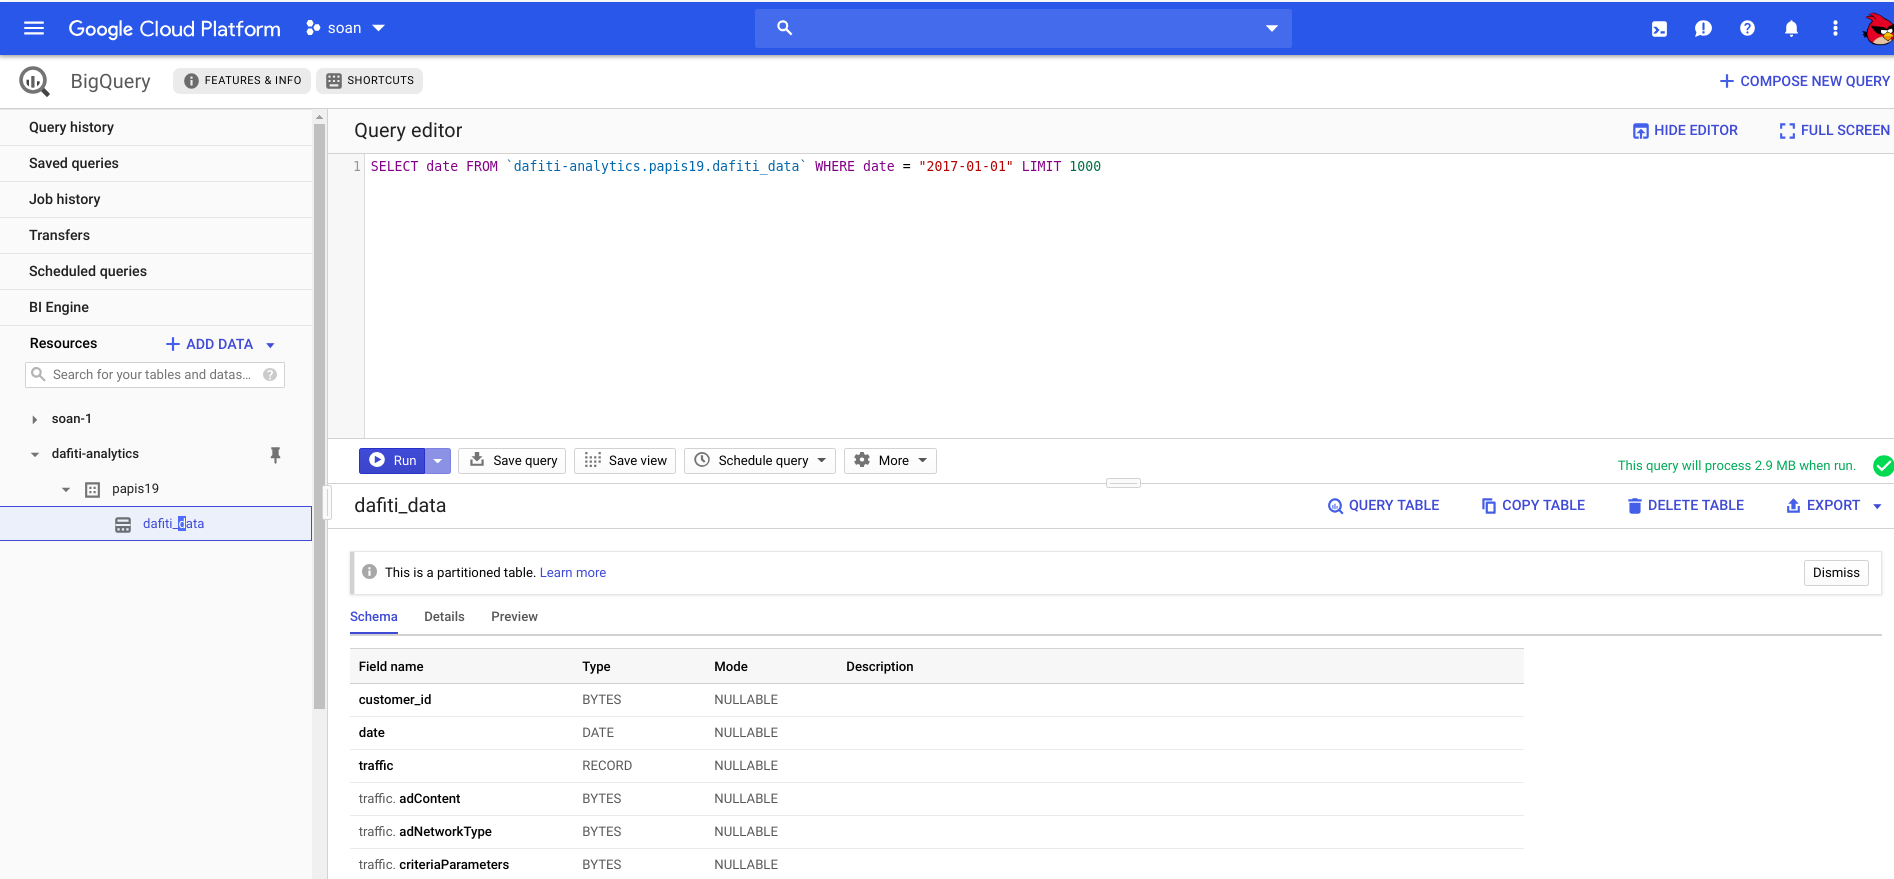


First, we need to create a Google Cloud Storage Bucket (similar to s3) where we'll be saving the whole dataset after processing.

Go to your [project console](https://console.cloud.google.com/home/dashboard) and find the option `Storage` on the side menu.

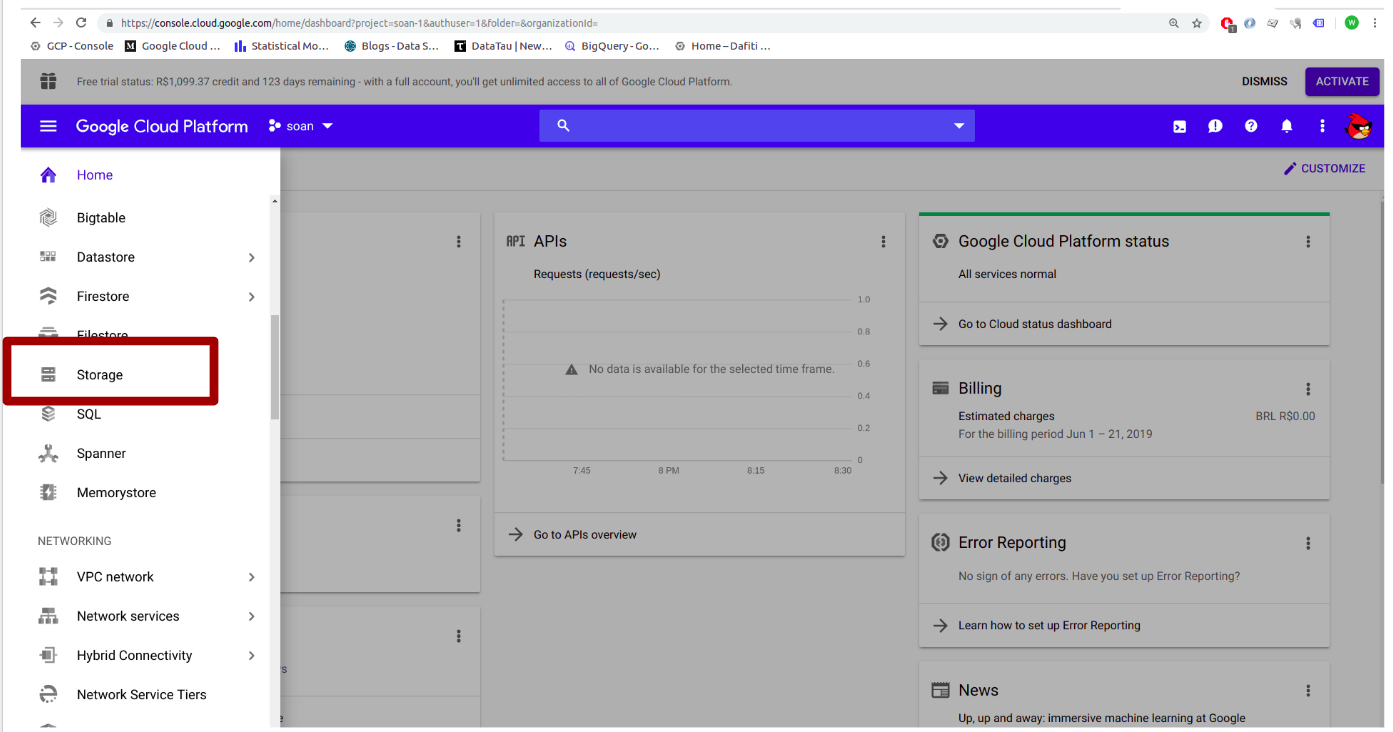

Create a bucket then where we'll be saving all of our data and models.

The name has to be unique; try using therefore the name "papis19" with the initials of your name.

In my case, it would be "papis19wjf".

Then, just `cd` to the folder `transform` and run the following command:


``` sh
python main.py --input_sql=preprocess/retrieve_data.sql \
               --train_init_date=2017-01-01 \
               --train_end_date=2017-01-26 \
               --test_init_date=2017-01-27 \
               --test_end_date=2017-01-31 \
               --project=your project name \
               --temp_location=gs://your bucket name/temp \
               --max_num_workers=10 \
               --staging_location=gs://your bucket name/staging \
               --tft_temp=gs://your bucket name/tft_temp \
               --tft_transform=gs://your bucket name/tft_transform \
               --nitems_filename=gs://your bucket name/nitems \
               --output_train_filename=gs://your bucket name/output_train \
               --output_test_filename=gs://your bucket name/output_test \
               --job_name=papis19 \
               --runner=DataflowRunner
```

This is where the beauty comes in: Beam will automatically build the whole graph processing strategy which gets translated by Dataflow into an execution plan that aims to distribute and optimize the data transformations as much as possible. Here's what you should see if everything works as expected:

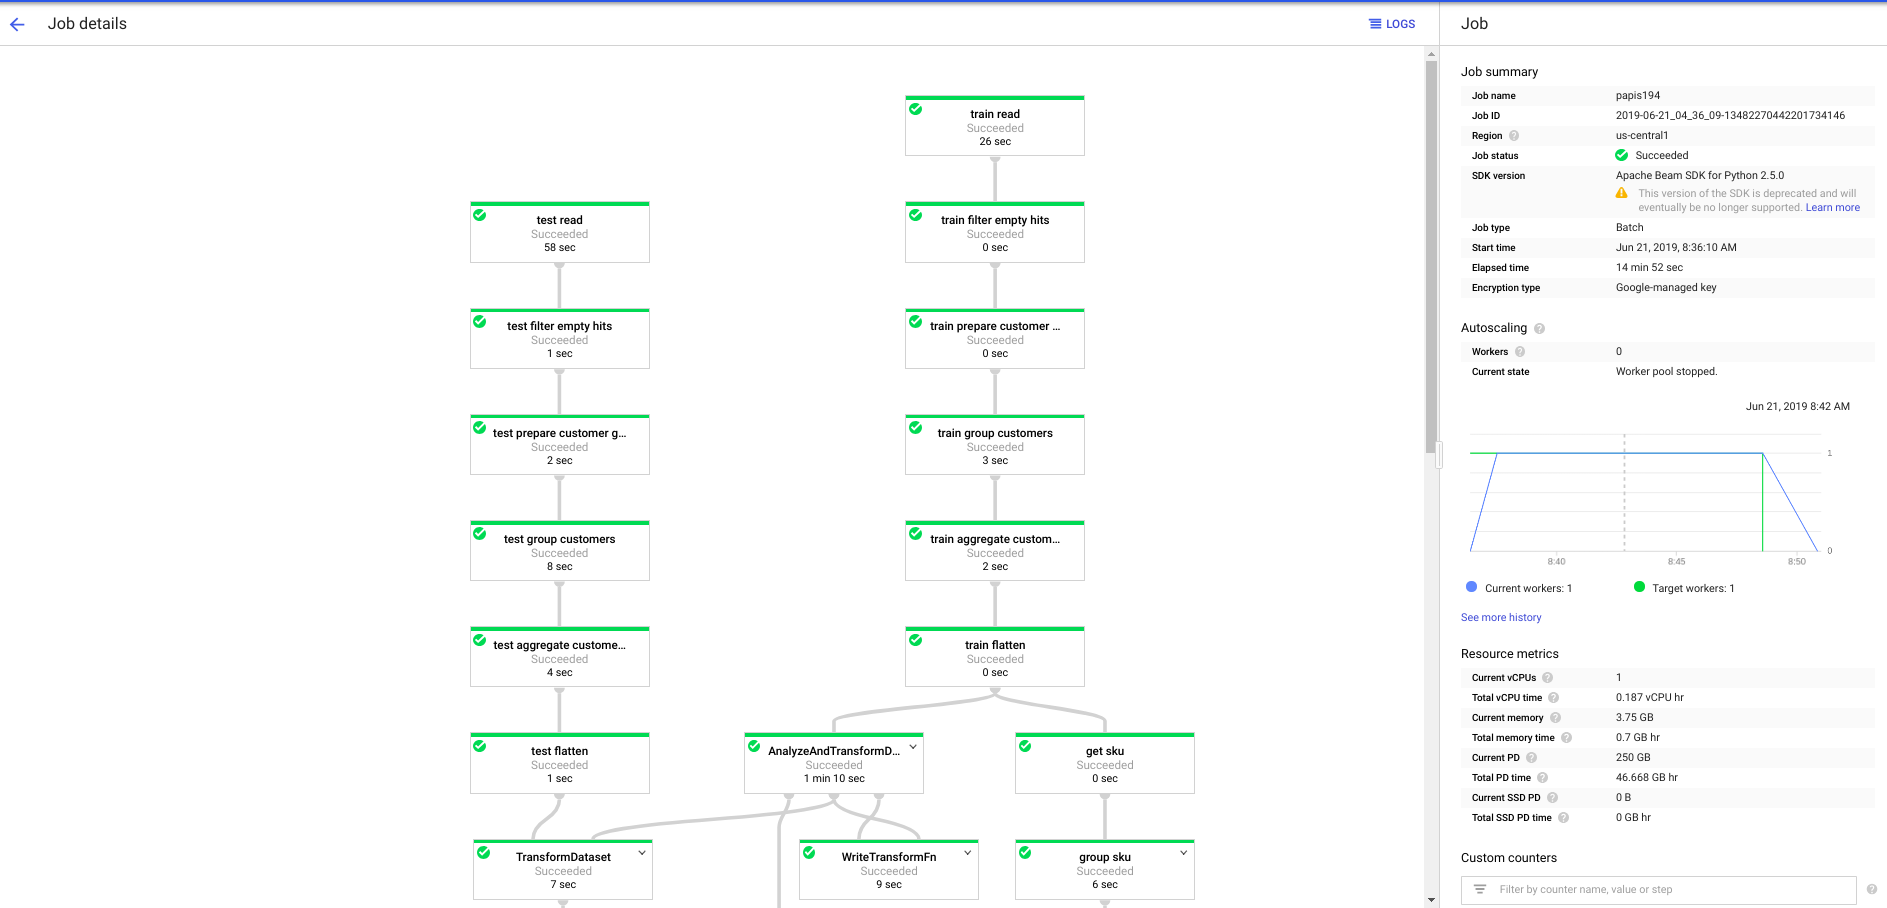

The end result of this transformation is data from Dafiti's BigQuery will be processed, transformed and results will be exported to the storage bucket we previously selected.

With this data, we can train our models to handle requests from customers.

# 2.3 Before We Move On....Unit Tests!

So far so good!

But there's one very important thing to keep in mind: these pipelines are processing hundres of gigabytes to finally build the training and testing data for our machine learning models.

If we leave any bug on them...it can cost up to millions ;)!!

You mission now is to open the student version of the unit tests in `tests` folder and finish the testings for data input pipelining. This will give you a good notion of how to test Beam's approach to processing data.

To run the unittests, you can just type `make test` and it will already run it for you.